In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import seaborn as sns

#these are user defined modules
import plot
import calculate


### Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

In [2]:
start_time = timeit.default_timer()
print(start_time)

7.89480955745645e-07


### Read Gender details

In [3]:
# read gender details - the column names are name, gender - change it to author, gender
gender = pd.read_csv('./data/name_gender_1970_2016_noAsians.csv')
gender.rename(columns={'name':'author'}, inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender.groupby('gender').size())
#TODO: also show proportion! What is the percentage of men and women?

print(gender['author'].nunique())

             author gender
0    nima mesgarani      m
1    james j. abbas      m
2  eberhart zrenner      m
3    emery n. brown      m
4        ilya rybak      m
['m' 'none' 'f']
gender
f        974493
m       4493870
none     325482
dtype: int64
1129473


### Read authors with start and end year details

In [4]:
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 15
#max_years = 15
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-start-end-year-publish-count.csv')
authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')

print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

print(authorStartEndCareerData.head())

#print("authorStartEndCareerData  %s", authorStartEndCareerData.shape[0])
print("author unique names  - ", authorStartEndCareerData['author'].nunique())
#print(authorStartEndCareerData[authorStartEndCareerData['author']=='a min tjoa'])

authorStartEndCareerData before filtering -  110468
authorStartEndCareerData after filtering -  110468
               author  start_year  end_year  pub_count  career_length
0          a min tjoa        1979      2015        193             36
1    a-imam al-sammak        1992      2008          6             16
2          a-xing zhu        1998      2015         16             17
3  a. a. (louis) beex        1980      2016         34             36
4     a. a. a. nasser        1993      2014          3             21
author unique names  -  110468


### Merge credible authors and their gender information

In [5]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')
print(authorStartEndCareerData.head())

print("authorStartEndCareerData with duplicates: %s", authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: %s", authorStartEndCareerData.shape[0])
# print(authorStartEndCareerData['author'].nunique())

#axes = authorStartEndCareerData.boxplot(column='pub_count', by='gender', return_type='axes')
#for ax in axes.values():
#    ax.set_ylim(0, 200)
#plt.show()

             author  start_year  end_year  pub_count  career_length gender
0        a min tjoa        1979      2015        193             36   none
1  a-imam al-sammak        1992      2008          6             16      m
2  a-imam al-sammak        1992      2008          6             16      m
3  a-imam al-sammak        1992      2008          6             16      m
4  a-imam al-sammak        1992      2008          6             16      m
authorStartEndCareerData with duplicates: %s 2365914
authorStartEndCareerData no duplicates: %s 110468


### Read Citation data

In [6]:
authorCitationsData = pd.read_csv('./data/authors_cite_2016_asiansAsNone.txt')
print('authorCitationsData before filtering - ',authorCitationsData.shape[0])
authorCitationsData = authorCitationsData[authorCitationsData["year"] >= 1970]
print('authorCitationsData after filtering - ',authorCitationsData.shape[0])

#id1 represents the author who cited
#id2 is the author who has been cited by id1 in year Y
authorCitationsData.rename(columns={'id2':'author'}, inplace=True)
print(authorCitationsData.head())

#Group by both year and author - multi index and hierarchial indexing
authorCitationsData = authorCitationsData.groupby(['year','author']).count().reset_index()
authorCitationsData.rename(columns={'id1':'num_cit'}, inplace=True)
print(authorCitationsData.head())

print(authorCitationsData[authorCitationsData.author == "stefano rizzi"])

##remove wrong data
#authorCitationsData = authorCitationsData[authorCitationsData["year"] > 1900]
#print(authorCitationsData[authorCitationsData.author=="a min tjoa"])

authorCitationsData before filtering -  1904817
authorCitationsData after filtering -  1904456
              id1        author  year
0   stefano rizzi    qiong fang  2006
1   stefano rizzi  jianlin feng  2006
2   stefano rizzi    hulin ding  2006
3  alberto abelló    qiong fang  2006
4  alberto abelló  jianlin feng  2006
   year            author  num_cit
0  1970       a. a. afifi        3
1  1970        a. fischer        1
2  1970   albert r. meyer        2
3  1970     alfred v. aho        2
4  1970  azriel rosenfeld        3
        year         author  num_cit
40916   2001  stefano rizzi        3
50419   2002  stefano rizzi        3
69943   2004  stefano rizzi        2
85473   2005  stefano rizzi        3
103873  2006  stefano rizzi        8
124816  2007  stefano rizzi       15
147849  2008  stefano rizzi       14
176394  2009  stefano rizzi        3
208024  2010  stefano rizzi        4
241006  2011  stefano rizzi        8
277945  2012  stefano rizzi       14


### Merge Citations with credible authors and their gender information

In [7]:
authorCitationsData = pd.merge(authorCitationsData, authorStartEndCareerData,  
                                          how="left", left_on="author", right_on="author")

print("authorCitationsData before filtering: %s", authorCitationsData.shape[0])
authorCitationsData = authorCitationsData.dropna(how='any')
print("authorCitationsData after filtering: %s", authorCitationsData.shape[0])



authorCitationsData before filtering: %s 346251
authorCitationsData after filtering: %s 175913


47622
   year            author  num_cit  start_year  end_year  pub_count  \
2  1970   albert r. meyer        2      1970.0    2002.0       74.0   
3  1970     alfred v. aho        2      1970.0    2015.0       66.0   
4  1970  azriel rosenfeld        3      1970.0    2007.0      385.0   
5  1970   david f. martin        3      1970.0    2003.0       15.0   
7  1970   donald p. gaver        1      1971.0    2014.0       14.0   

   career_length gender  
2           32.0      m  
3           45.0      m  
4           37.0      m  
5           33.0   none  
7           43.0      m  


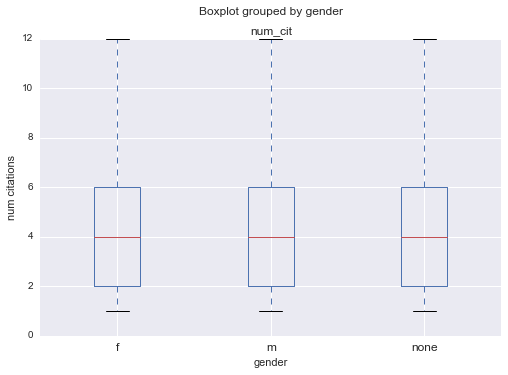

In [8]:
#print(authorCitationsData.head(n=2))
print(authorCitationsData['author'].nunique())
#print(authorCitationsData.shape[0])

print(authorCitationsData.head())
#print(authorCitationsData[authorCitationsData.author=="stefano rizzi"])


ax = authorCitationsData.boxplot(column='num_cit', by='gender', showfliers=False)
ax.set_ylabel("num citations")
ax.set_xlabel("gender")
plt.show()

### There are some differences between publication and citation data which is collected by DBLP and Aminer respectively
#### Data found for authors whose work were cited in the years which are lesser than their starting year of publishing. For our analysis these data are removed. Whereas author's work will be cited even after he/she ends their career

In [9]:
print('authorCitationsData before filtering', authorCitationsData.shape[0])
temp =  authorCitationsData[authorCitationsData['year'] < authorCitationsData['start_year']]
print(temp.shape[0],' rows were present')

authorCitationsData = authorCitationsData[authorCitationsData['year'] >= authorCitationsData['start_year']]
authorCitationsData = authorCitationsData.reset_index(drop = True)

print('authorCitationsData after filtering', authorCitationsData.shape[0])
print(authorCitationsData.head(10))

authorCitationsData before filtering 175913
33  rows were present
authorCitationsData after filtering 175880
   year             author  num_cit  start_year  end_year  pub_count  \
0  1970    albert r. meyer        2      1970.0    2002.0       74.0   
1  1970      alfred v. aho        2      1970.0    2015.0       66.0   
2  1970   azriel rosenfeld        3      1970.0    2007.0      385.0   
3  1970    david f. martin        3      1970.0    2003.0       15.0   
4  1970      gerald estrin        3      1970.0    2002.0       17.0   
5  1970   james l. elshoff        2      1970.0    1991.0       11.0   
6  1970  jeffrey d. ullman        2      1970.0    2015.0      220.0   
7  1970  leonard kleinrock        4      1970.0    2014.0      111.0   
8  1970     paul t. hulina        2      1970.0    1999.0       23.0   
9  1970    robert f. rosin        2      1970.0    1992.0        9.0   

   career_length gender  
0           32.0      m  
1           45.0      m  
2           37.0    

### Cohort Analysis on all authors for 15 years

In [10]:
groupByYearData = authorCitationsData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 1, 'num_cit')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

       year            author  num_cit  start_year  end_year  pub_count  \
7982   1995  donatella sciuto       30      1985.0    2016.0      345.0   
11319  1997  donatella sciuto      212      1985.0    2016.0      345.0   
13714  1998  donatella sciuto       44      1985.0    2016.0      345.0   
16612  1999  donatella sciuto      275      1985.0    2016.0      345.0   
20612  2000  donatella sciuto       32      1985.0    2016.0      345.0   
25305  2001  donatella sciuto       36      1985.0    2016.0      345.0   
37780  2003  donatella sciuto      116      1985.0    2016.0      345.0   
44033  2004  donatella sciuto      609      1985.0    2016.0      345.0   
51491  2005  donatella sciuto      353      1985.0    2016.0      345.0   
61633  2006  donatella sciuto      209      1985.0    2016.0      345.0   

       career_length gender  
7982            31.0      f  
11319           31.0      f  
13714           31.0      f  
16612           31.0      f  
20612           31.0    

In [11]:
years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]


C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


1970
[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
get_cohort_stats
RETURNED FROM get_cohort_stats
          mean       std    mean_f  median_f     std_f    mean_m  median_m  \
1970  0.182629  0.014336  0.184466       0.0  0.068638  0.258436       0.0   
1971  0.140845  0.011189  0.000000       0.0  0.000000  0.128395       0.0   

         std_m    mean_n  median_n     std_n  
1970  0.022199  0.068966       0.0  0.014483  
1971  0.013428  0.177340       0.0  0.021289  
   cohort_start_year  cohort_size    year      gini
0             1970.0       2130.0  1970.0  0.933607
1             1970.0       2130.0  1971.0  0.935132
1970    0.933607
1971    0.935132
dtype: float64
   year      gini
0  1970  0.933607
1  1971  0.935132
2  1972  0.968798
3  1973  0.949205

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


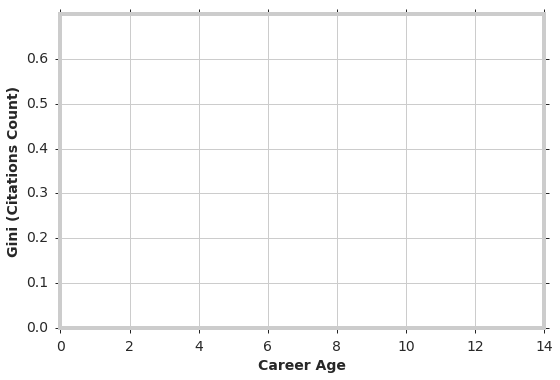

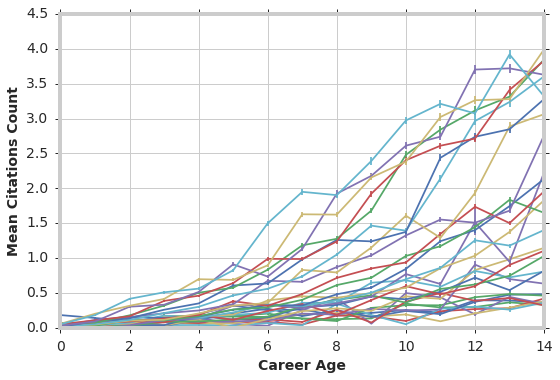

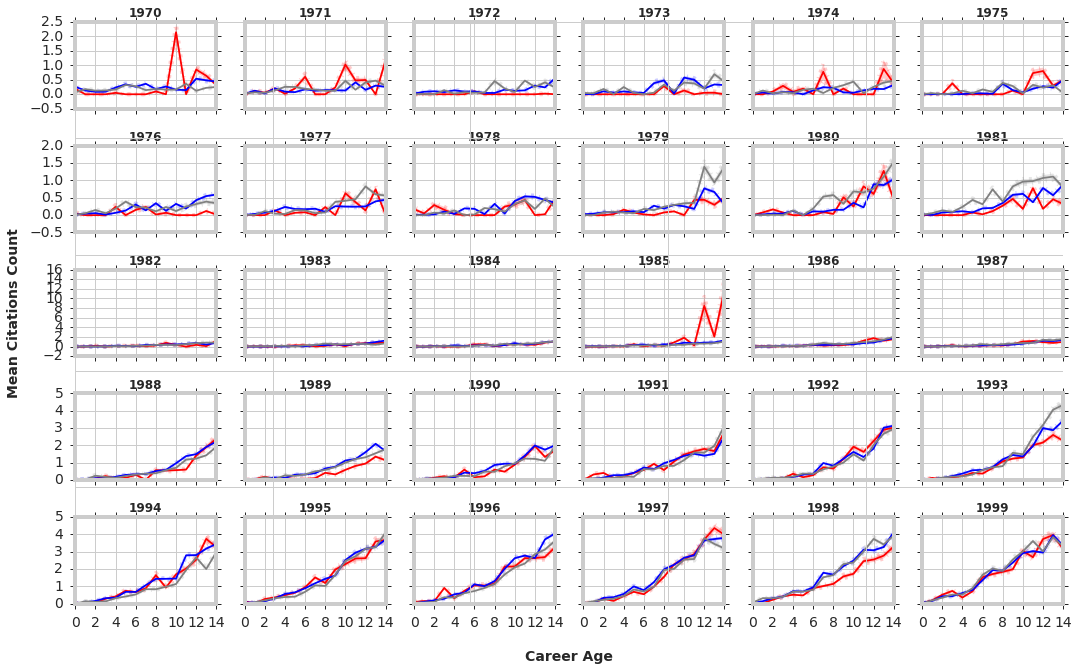

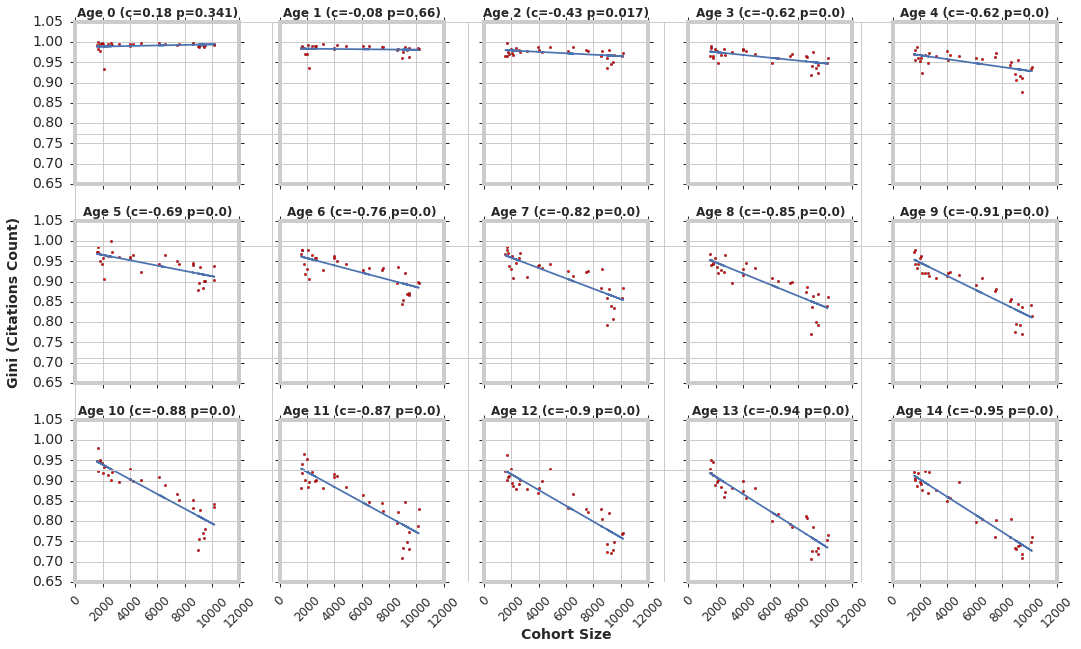

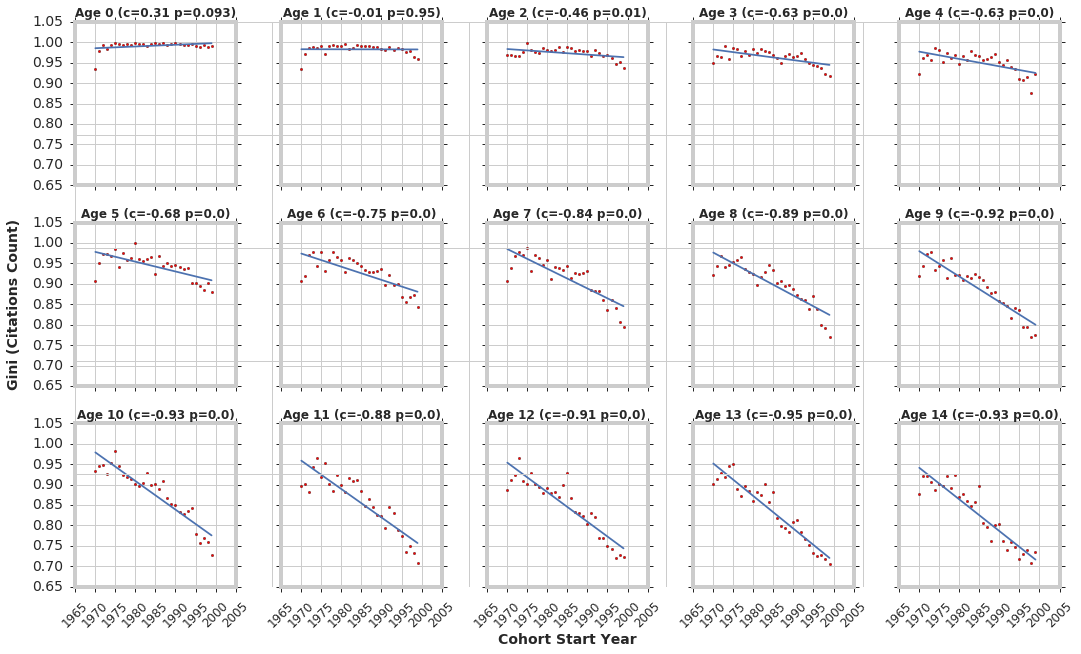

In [12]:
#print(plt.style.available)

#just for debugging
#reload(plot)
#reload(calculate)
plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')

1970
[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
get_cohort_stats
RETURNED FROM get_cohort_stats
          mean       std    mean_f  median_f     std_f    mean_m  median_m  \
1970  0.182629  0.014336  0.184466       0.0  0.068638  0.258436       0.0   
1971  0.323474  0.019510  0.184466       0.0  0.068638  0.386831       0.0   

         std_m    mean_n  median_n     std_n  
1970  0.022199  0.068966       0.0  0.014483  
1971  0.029090  0.246305       0.0  0.025156  
   cohort_start_year  cohort_size    year      gini
0             1970.0       2130.0  1970.0  0.933607
1             1970.0       2130.0  1971.0  0.895857
1970    0.933607
1971    0.895857
dtype: float64
   year      gini
0  1970  0.933607
1  1971  0.895857
2  1972  0.873397
3  1973  0.861282

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


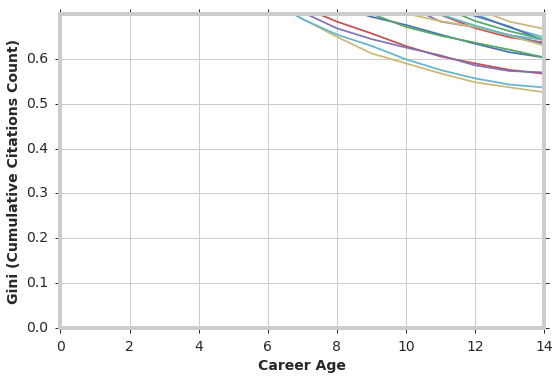

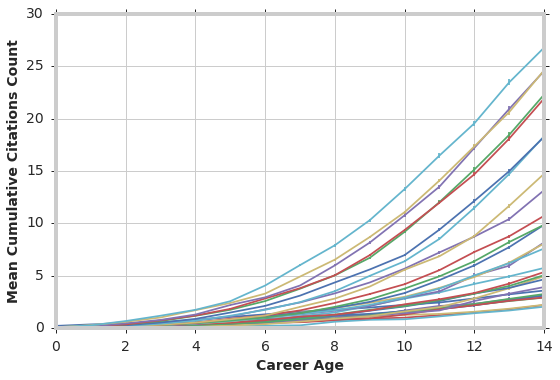

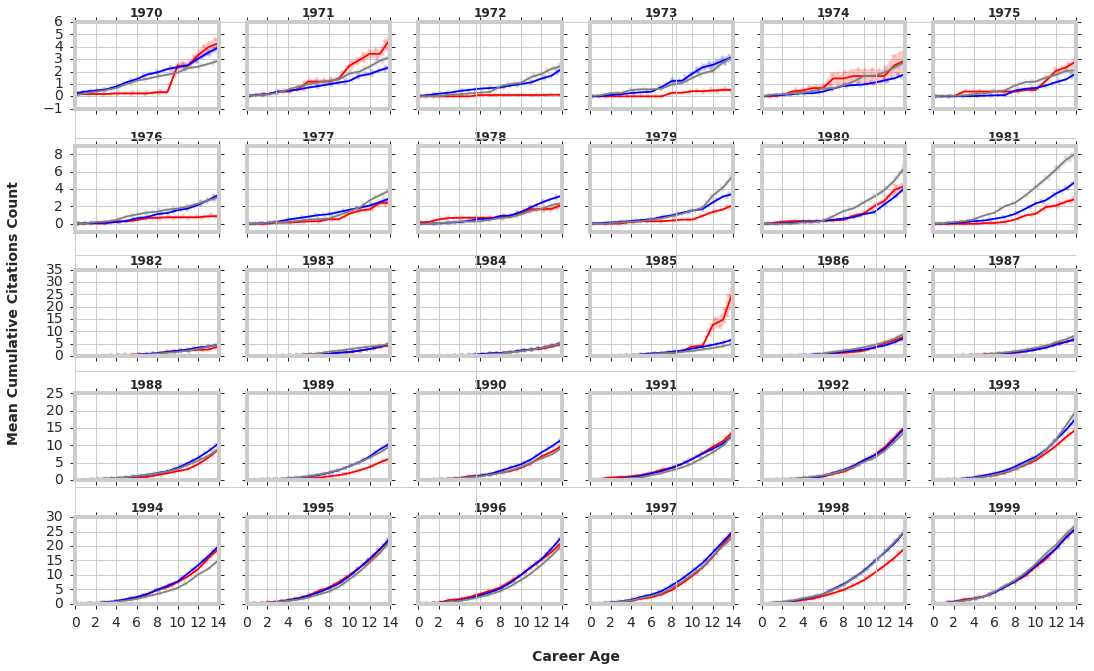

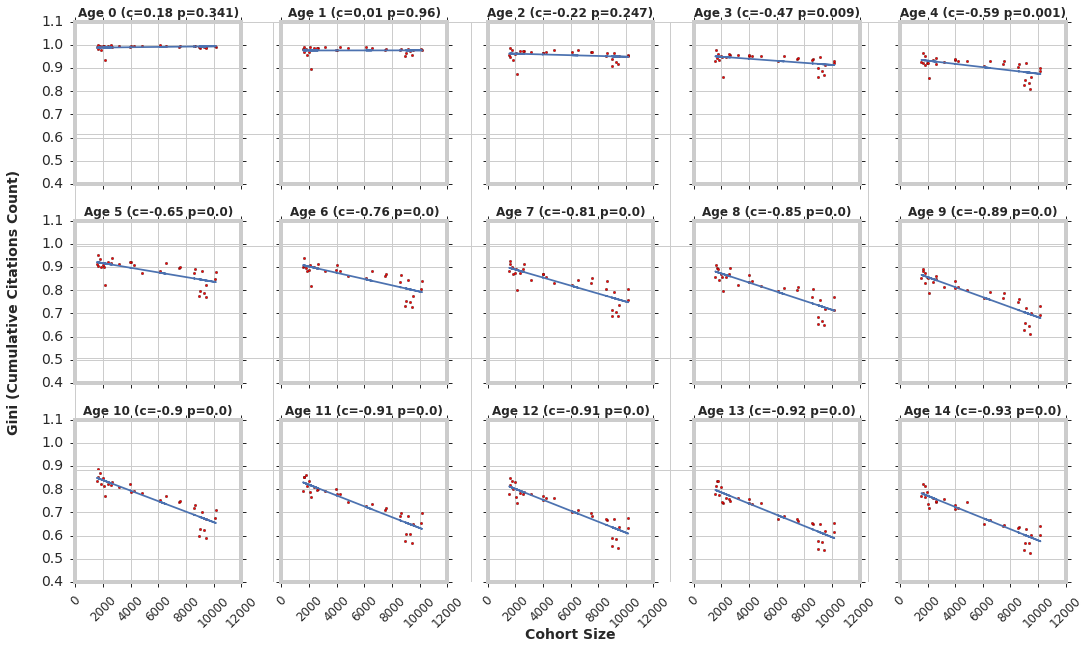

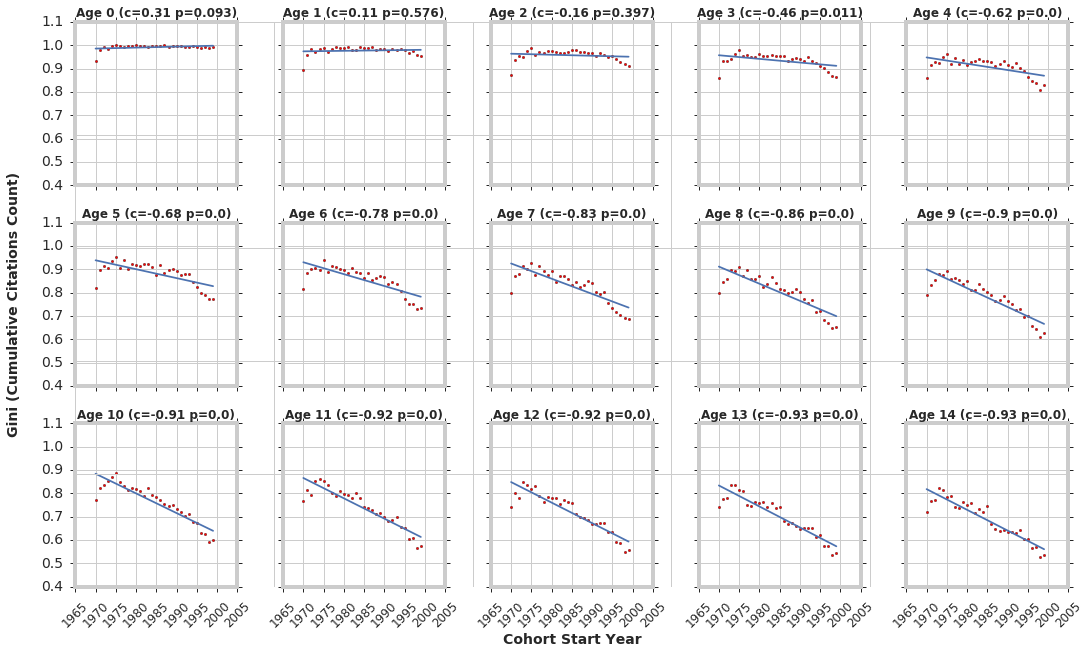

In [13]:
#just for debugging
#reload(plot)
#reload(calculate)
plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')

Why is there a sudden increase in mean citation count for cohort started in 1985?

In [14]:
_1985Authors = authorCitationsData[authorCitationsData['start_year'] == 1985] 
_1985Authors.shape

(4837, 8)

In [15]:
_1985Authors.columns

Index(['year', 'author', 'num_cit', 'start_year', 'end_year', 'pub_count',
       'career_length', 'gender'],
      dtype='object')

In [16]:
_1985Authors.sort(columns=['num_cit'], axis = 0, ascending=False,inplace=False)

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,year,author,num_cit,start_year,end_year,pub_count,career_length,gender
166896,2014,donatella sciuto,26600,1985.0,2016.0,345.0,31.0,f
174744,2015,donatella sciuto,11694,1985.0,2016.0,345.0,31.0,f
154230,2013,donatella sciuto,5641,1985.0,2016.0,345.0,31.0,f
139568,2012,donatella sciuto,1580,1985.0,2016.0,345.0,31.0,f
96434,2009,donatella sciuto,652,1985.0,2016.0,345.0,31.0,f
44033,2004,donatella sciuto,609,1985.0,2016.0,345.0,31.0,f
72398,2007,donatella sciuto,589,1985.0,2016.0,345.0,31.0,f
110762,2010,donatella sciuto,531,1985.0,2016.0,345.0,31.0,f
51491,2005,donatella sciuto,353,1985.0,2016.0,345.0,31.0,f
16612,1999,donatella sciuto,275,1985.0,2016.0,345.0,31.0,f


In [17]:
_1995_year_1985Authors = _1985Authors[_1985Authors['year'] >= 1995]
_1995_2000_year_1985Authors = _1985Authors[_1985Authors['year'] <= 2000]
print(_1995_2000_year_1985Authors.shape)
_1995_2000_year_1985Authors.head(10)

(1022, 8)


,year,author,num_cit,start_year,end_year,pub_count,career_length,gender
1374,1985,eiji okamoto,2,1985.0,2016.0,188.0,31.0,m
1401,1985,jieh hsiang,4,1985.0,2015.0,68.0,30.0,m
1502,1986,anas mahmoud,2,1985.0,2015.0,21.0,30.0,m
1584,1986,hideo shimazu,5,1985.0,2010.0,29.0,25.0,m
1612,1986,john hershberger,2,1985.0,2016.0,115.0,31.0,none
1618,1986,keith e. williamson,3,1985.0,2001.0,8.0,16.0,m
1626,1986,l. paul chew,1,1985.0,2009.0,40.0,24.0,m
1653,1986,michael shebanow,8,1985.0,2013.0,9.0,28.0,m
1656,1986,michel dagenais,1,1985.0,2015.0,39.0,30.0,m
1658,1986,nan niu,2,1985.0,2015.0,55.0,30.0,none


In [18]:
temp_group = _1995_2000_year_1985Authors.groupby(by=['year','author'])['num_cit']
temp = temp_group.sum().reset_index().sort_values(by='num_cit',ascending=False)
temp.head()

#print(temp1['id2'].unique())

,year,author,num_cit
758,1999,donatella sciuto,275
539,1997,donatella sciuto,212
642,1998,donatella sciuto,44
984,2000,peter van den besselaar,33
907,2000,donatella sciuto,32


In [19]:
donatella = _1985Authors[_1985Authors['author'] == 'donatella sciuto']
donatella

,year,author,num_cit,start_year,end_year,pub_count,career_length,gender
7982,1995,donatella sciuto,30,1985.0,2016.0,345.0,31.0,f
11319,1997,donatella sciuto,212,1985.0,2016.0,345.0,31.0,f
13714,1998,donatella sciuto,44,1985.0,2016.0,345.0,31.0,f
16612,1999,donatella sciuto,275,1985.0,2016.0,345.0,31.0,f
20612,2000,donatella sciuto,32,1985.0,2016.0,345.0,31.0,f
25305,2001,donatella sciuto,36,1985.0,2016.0,345.0,31.0,f
37780,2003,donatella sciuto,116,1985.0,2016.0,345.0,31.0,f
44033,2004,donatella sciuto,609,1985.0,2016.0,345.0,31.0,f
51491,2005,donatella sciuto,353,1985.0,2016.0,345.0,31.0,f
61633,2006,donatella sciuto,209,1985.0,2016.0,345.0,31.0,f


C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


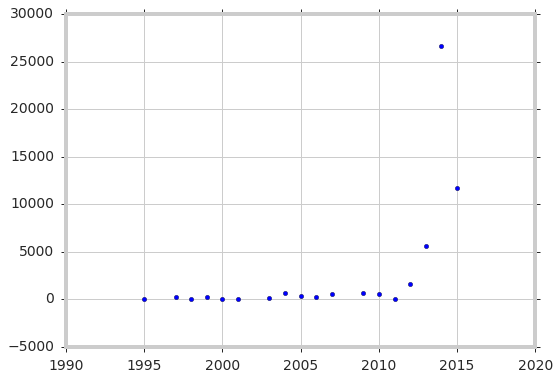

In [20]:
plt.scatter(x=donatella['year'],y=donatella['num_cit'])

In [21]:
authorCitationsData[authorCitationsData['author'] == 'donatella sciuto']

,year,author,num_cit,start_year,end_year,pub_count,career_length,gender
7982,1995,donatella sciuto,30,1985.0,2016.0,345.0,31.0,f
11319,1997,donatella sciuto,212,1985.0,2016.0,345.0,31.0,f
13714,1998,donatella sciuto,44,1985.0,2016.0,345.0,31.0,f
16612,1999,donatella sciuto,275,1985.0,2016.0,345.0,31.0,f
20612,2000,donatella sciuto,32,1985.0,2016.0,345.0,31.0,f
25305,2001,donatella sciuto,36,1985.0,2016.0,345.0,31.0,f
37780,2003,donatella sciuto,116,1985.0,2016.0,345.0,31.0,f
44033,2004,donatella sciuto,609,1985.0,2016.0,345.0,31.0,f
51491,2005,donatella sciuto,353,1985.0,2016.0,345.0,31.0,f
61633,2006,donatella sciuto,209,1985.0,2016.0,345.0,31.0,f


## Research Question 1
Is inequality increasing with increasing competition (i.e. do larger cohorts jhave higher inequality?)?
Analyse the correlation plots. Plot signigicance of correlation between cohort size and gini for each career age.

## Research Question 2
How is the position of men and women changing as inequality increases?
We see that the mean cumulative productivity and success are increasing for both groups is a similar way. Some cohorts are different but for most of them no big gender differences are visible.



### Regression Analysis of mean productivity on Inequality for all authors for 15 years
- There is no relation at all - Reg. coefficient is 0

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

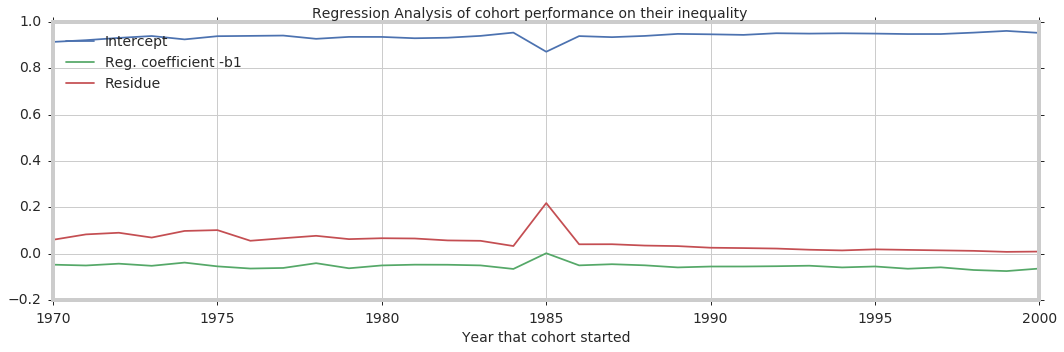

In [22]:
#just for debugging
#reload(plot)
#reload(calculate)
data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#print(data.head())

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

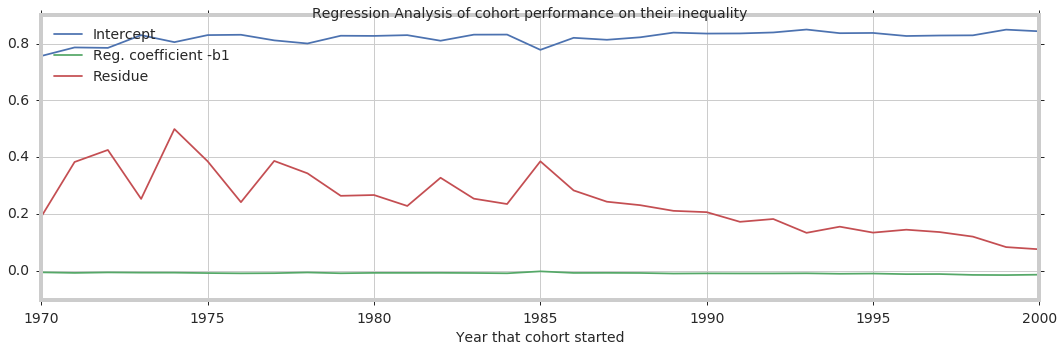

In [23]:
#just for debugging
#reload(plot)
#reload(calculate)
data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

       year            author  num_cit  start_year  end_year  pub_count  \
7982   1995  donatella sciuto       30      1985.0    2016.0      345.0   
11319  1997  donatella sciuto      212      1985.0    2016.0      345.0   
13714  1998  donatella sciuto       44      1985.0    2016.0      345.0   
16612  1999  donatella sciuto      275      1985.0    2016.0      345.0   
20612  2000  donatella sciuto       32      1985.0    2016.0      345.0   
25305  2001  donatella sciuto       36      1985.0    2016.0      345.0   
37780  2003  donatella sciuto      116      1985.0    2016.0      345.0   
44033  2004  donatella sciuto      609      1985.0    2016.0      345.0   
51491  2005  donatella sciuto      353      1985.0    2016.0      345.0   
61633  2006  donatella sciuto      209      1985.0    2016.0      345.0   

       career_length gender  
7982            31.0      f  
11319           31.0      f  
13714           31.0      f  
16612           31.0      f  
20612           31.0    

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

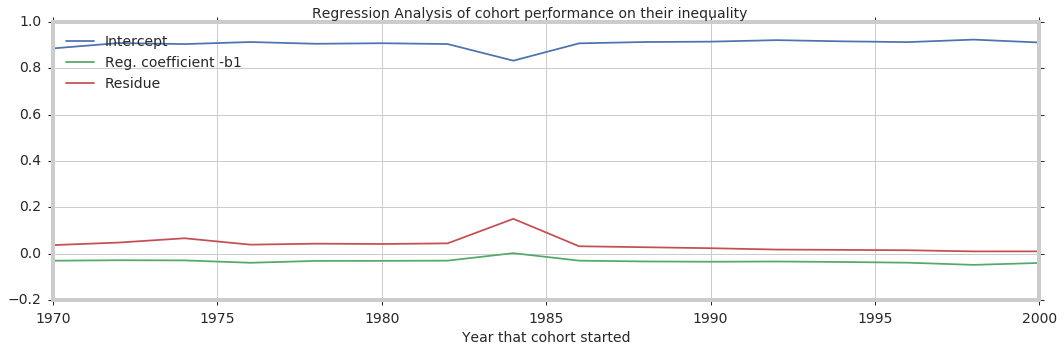

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

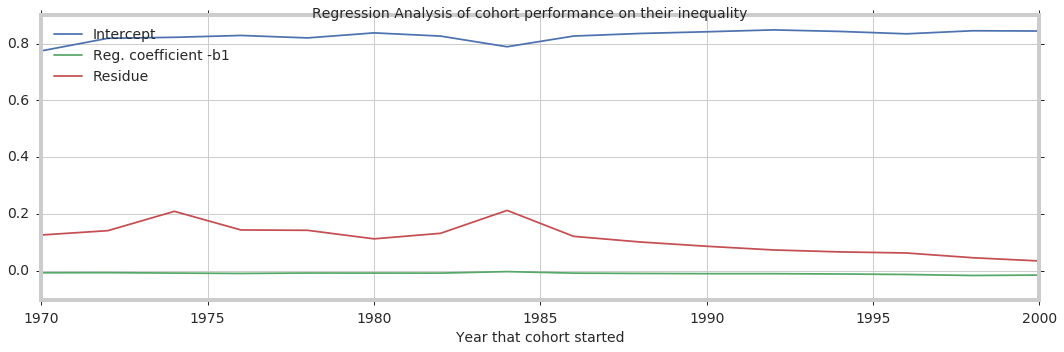

In [24]:
groupByYearData = authorCitationsData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_cit')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 30 years

       year            author  num_cit  start_year  end_year  pub_count  \
7982   1995  donatella sciuto       30      1985.0    2016.0      345.0   
11319  1997  donatella sciuto      212      1985.0    2016.0      345.0   
13714  1998  donatella sciuto       44      1985.0    2016.0      345.0   
16612  1999  donatella sciuto      275      1985.0    2016.0      345.0   
20612  2000  donatella sciuto       32      1985.0    2016.0      345.0   
25305  2001  donatella sciuto       36      1985.0    2016.0      345.0   
37780  2003  donatella sciuto      116      1985.0    2016.0      345.0   
44033  2004  donatella sciuto      609      1985.0    2016.0      345.0   
51491  2005  donatella sciuto      353      1985.0    2016.0      345.0   
61633  2006  donatella sciuto      209      1985.0    2016.0      345.0   

       career_length gender  
7982            31.0      f  
11319           31.0      f  
13714           31.0      f  
16612           31.0      f  
20612           31.0    

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

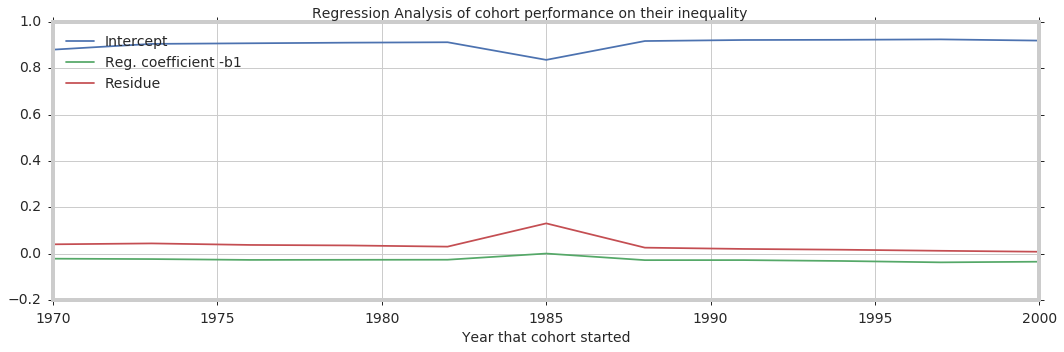

C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\wagnerca\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings

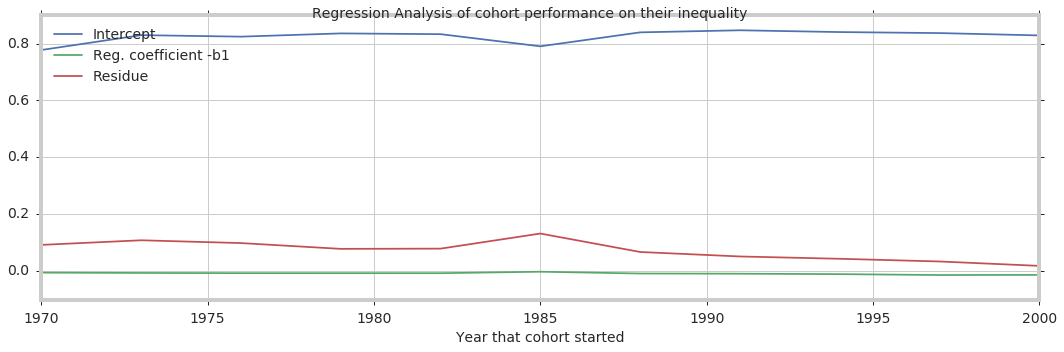

In [25]:
groupByYearData = authorCitationsData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_cit')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

years = groupByYearData['year'].unique()
years = sorted(years)
print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)